In [4]:
# import Automatic Differentiation 
# You may use Neural Network Framework, but only for building MLPs
# i.e. no fancy probabilistic implementations
using Pkg
# Pkg.instantiate()
using Flux
using MLDatasets
using Statistics
using Logging
using Test
using Random
using StatsFuns: log1pexp
Random.seed!(412414);

In [124]:
# log-pdf of x under Factorized or Diagonal Gaussian N(x|μ,σI)
function factorized_gaussian_log_density(mu, logsig,xs)
  """
  mu and logsig either same size as x in batch or same as whole batch
  returns a 1 x batchsize array of likelihoods
  """
  σ = exp.(logsig)
  return sum((-1/2)*log.(2π*σ.^2) .+ -1/2 * ((xs .- mu).^2)./(σ.^2),dims=1)
end

factorized_gaussian_log_density (generic function with 1 method)

In [125]:
# log-pdf of x under Bernoulli 
function bernoulli_log_density(logit_means,x)
  """Numerically stable log_likelihood under bernoulli by accepting μ/(1-μ)"""
  b = x .* 2 .- 1 # {0,1} -> {-1,1}
  return - log1pexp.(-b .* logit_means)
end

bernoulli_log_density (generic function with 1 method)

In [126]:
## This is really bernoulli
@testset "test stable bernoulli" begin
  using Distributions
  x = rand(10,100) .> 0.5
  μ = rand(10)
  logit_μ = log.(μ./(1 .- μ))
  @test logpdf.(Bernoulli.(μ),x) ≈ bernoulli_log_density(logit_μ,x)
  # over i.i.d. batch
  @test sum(logpdf.(Bernoulli.(μ),x),dims=1) ≈ sum(bernoulli_log_density(logit_μ,x),dims=1)
end

Test Summary:         | Pass  Total
test stable bernoulli |    2      2


Test.DefaultTestSet("test stable bernoulli", Any[], 2, false)

In [127]:
# sample from Diagonal Gaussian x~N(μ,σI) (hint: use reparameterization trick here)
sample_diag_gaussian(μ,logσ) = (ϵ = randn(size(μ)); μ .+ exp.(logσ).*ϵ)
# sample from Bernoulli (this can just be supplied by library)
sample_bernoulli(θ) = rand.(Bernoulli.(θ))

sample_bernoulli (generic function with 1 method)

In [128]:
# Load MNIST data, binarise it, split into train and test sets (10000 each) and partition train into mini-batches of M=100.
# You may use the utilities from A2, or dataloaders provided by a framework
function load_binarized_mnist(train_size=1000, test_size=1000)
  train_x, train_label = MNIST.traindata(1:train_size);
  test_x, test_label = MNIST.testdata(1:test_size);
  @info "Loaded MNIST digits with dimensionality $(size(train_x))"
  train_x = reshape(train_x, 28*28,:)
  test_x = reshape(test_x, 28*28,:)
  @info "Reshaped MNIST digits to vectors, dimensionality $(size(train_x))"
  train_x = train_x .> 0.5; #binarize
  test_x = test_x .> 0.5; #binarize
  @info "Binarized the pixels"
  return (train_x, train_label), (test_x, test_label)
end

load_binarized_mnist (generic function with 3 methods)

In [129]:
function batch_data((x,label)::Tuple, batch_size=100)
  """
  Shuffle both data and image and put into batches
  """
  N = size(x)[end] # number of examples in set
  rand_idx = shuffle(1:N) # randomly shuffle batch elements
  batch_idx = Iterators.partition(rand_idx,batch_size) # split into batches
  batch_x = [x[:,i] for i in batch_idx]
  batch_label = [label[i] for i in batch_idx]
  return zip(batch_x, batch_label)
end

batch_data (generic function with 2 methods)

In [130]:
# if you only want to batch xs
batch_x(x::AbstractArray, batch_size=100) = first.(batch_data((x,zeros(size(x)[end])),batch_size))

batch_x (generic function with 2 methods)

In [132]:
### Implementing the model

## Load the Data
train_data, test_data = load_binarized_mnist(5000);
train_x, train_label = train_data;
test_x, test_label = test_data;

┌ Info: Loaded MNIST digits with dimensionality (28, 28, 5000)
└ @ Main In[128]:6
┌ Info: Reshaped MNIST digits to vectors, dimensionality (784, 5000)
└ @ Main In[128]:9
┌ Info: Binarized the pixels
└ @ Main In[128]:12


In [133]:
## Test the dimensions of loaded data
@testset "correct dimensions" begin
@test size(train_x) == (784,1000)
@test size(train_label) == (1000,)
@test size(test_x) == (784,1000)
@test size(test_label) == (1000,)
end

correct dimensions: Test Failed at In[133]:3
  Expression: size(train_x) == (784, 1000)
   Evaluated: (784, 5000) == (784, 1000)
Stacktrace:
 [1] top-level scope at In[133]:3
 [2] top-level scope at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Test\src\Test.jl:1113
 [3] top-level scope at In[133]:3
correct dimensions: Test Failed at In[133]:4
  Expression: size(train_label) == (1000,)
   Evaluated: (5000,) == (1000,)
Stacktrace:
 [1] top-level scope at In[133]:4
 [2] top-level scope at D:\buildbot\worker\package_win64\build\usr\share\julia\stdlib\v1.4\Test\src\Test.jl:1113
 [3] top-level scope at In[133]:3
Test Summary:      | Pass  Fail  Total
correct dimensions |    2     2      4


TestSetException: Some tests did not pass: 2 passed, 2 failed, 0 errored, 0 broken.

In [134]:
## Model Dimensionality
# #### Set up model according to Appendix C (using Bernoulli decoder for Binarized MNIST)
# Set latent dimensionality=2 and number of hidden units=500.
Dz, Dh = 2, 500
Ddata = 28^2

784

In [135]:
log_prior(z) = factorized_gaussian_log_density(0, 0, z)

log_prior (generic function with 1 method)

In [136]:
decoder = Chain(Dense(Dz, Dh, tanh), Dense(Dh, Ddata))

Chain(Dense(2, 500, tanh), Dense(500, 784))

In [137]:
function log_likelihood(x,z)
  """ Compute log likelihood log_p(x|z)"""
  θ = decoder(z)
  return  sum(bernoulli_log_density(θ, x), dims=1) # return likelihood for each element in batch
end

log_likelihood (generic function with 1 method)

In [138]:
joint_log_density(x, z) = log_prior(z) .+ log_likelihood(x, z)

joint_log_density (generic function with 1 method)

In [139]:
function unpack_gaussian_params(θ)
  μ, logσ = θ[1:2,:], θ[3:end,:]
  return  μ, logσ
end

unpack_gaussian_params (generic function with 1 method)

In [140]:
encoder = Chain(Dense(Ddata, Dh, tanh), Dense(Dh, 2*Dz), unpack_gaussian_params)#TODO
# Hint: last "layer" in Chain can be 'unpack_gaussian_params'

Chain(Dense(784, 500, tanh), Dense(500, 4), unpack_gaussian_params)

In [141]:
log_q(q_μ, q_logσ, z) = factorized_gaussian_log_density(q_μ, q_logσ, z) #TODO: write log likelihood under variational distribution.

log_q (generic function with 1 method)

In [142]:
function elbo(x)
  q_μ, q_logσ = encoder(x)#TODO variational parameters from data
  z = sample_diag_gaussian(q_μ, q_logσ)#TODO: sample from variational distribution
  joint_ll = joint_log_density(x, z) #TODO: joint likelihood of z and x under model
  log_q_z = log_q(q_μ, q_logσ, z)#TODO: likelihood of z under variational distribution
  elbo_estimate = mean(joint_ll .- log_q_z)#TODO: Scalar value, mean variational evidence lower bound over batch
  return elbo_estimate
end

elbo (generic function with 1 method)

In [143]:
function loss(x)
  return -elbo(x) #TODO: scalar value for the variational loss over elements in the batch
end

loss (generic function with 1 method)

In [144]:
# Training with gradient optimization:
# See example_flux_model.jl for inspiration

function train_model_params!(loss, encoder, decoder, train_x, test_x; nepochs=10)
  # model params
  ps = Flux.params(encoder, decoder)#TODO parameters to update with gradient descent
  # ADAM optimizer with default parameters
  opt = ADAM()
  # over batches of the data
  for i in 1:nepochs 
    for d in batch_x(train_x)
     # compute gradients with respect to variational loss over batch 
      gs = Flux.gradient(ps) do
                return loss(d)
            end
    #TODO update the paramters with gradients
      Flux.Optimise.update!(opt, ps, gs)   
    end
    if i%1 == 0 # change 1 to higher number to compute and print less frequently
      @info "Test loss at epoch $i: $(loss(batch_x(test_x)[1]))"
    end
  end
  @info "Parameters of encoder and decoder trained!"
end

train_model_params! (generic function with 1 method)

In [145]:
## Train the model
train_model_params!(loss,encoder,decoder,train_x,test_x, nepochs=100)

┌ Info: Test loss at epoch 1: 207.34438717149385
└ @ Main In[144]:20
┌ Info: Test loss at epoch 2: 193.75021440788979
└ @ Main In[144]:20
┌ Info: Test loss at epoch 3: 190.26810002592188
└ @ Main In[144]:20
┌ Info: Test loss at epoch 4: 194.3386259686358
└ @ Main In[144]:20
┌ Info: Test loss at epoch 5: 180.47477106349785
└ @ Main In[144]:20
┌ Info: Test loss at epoch 6: 183.85620169569796
└ @ Main In[144]:20
┌ Info: Test loss at epoch 7: 178.6614011644195
└ @ Main In[144]:20
┌ Info: Test loss at epoch 8: 172.45868330462403
└ @ Main In[144]:20
┌ Info: Test loss at epoch 9: 175.6180396248997
└ @ Main In[144]:20
┌ Info: Test loss at epoch 10: 179.7458380926538
└ @ Main In[144]:20
┌ Info: Test loss at epoch 11: 168.79646932167944
└ @ Main In[144]:20
┌ Info: Test loss at epoch 12: 182.6507768841546
└ @ Main In[144]:20
┌ Info: Test loss at epoch 13: 180.9869834230333
└ @ Main In[144]:20
┌ Info: Test loss at epoch 14: 171.1798430646526
└ @ Main In[144]:20
┌ Info: Test loss at epoch 15: 178.5

In [146]:
### Save the trained model!
using BSON:@save
cd(@__DIR__)
@info "Changed directory to $(@__DIR__)"
save_dir = "trained_models"
if !(isdir(save_dir))
  mkdir(save_dir)
  @info "Created save directory $save_dir"
end
@save joinpath(save_dir,"encoder_params.bson") encoder
@save joinpath(save_dir,"decoder_params.bson") decoder
@info "Saved model params in $save_dir"

┌ Info: Changed directory to C:\Users\jeffr\Desktop\STA414-2020-A3-jeffreyblair
└ @ Main In[146]:4
┌ Info: Saved model params in trained_models
└ @ Main In[146]:12


In [147]:
## Load the trained model!
using BSON:@load
cd(@__DIR__)
@info "Changed directory to $(@__DIR__)"
load_dir = "trained_models"
@load joinpath(load_dir,"encoder_params.bson") encoder
@load joinpath(load_dir,"decoder_params.bson") decoder
@info "Load model params from $load_dir"

┌ Info: Changed directory to C:\Users\jeffr\Desktop\STA414-2020-A3-jeffreyblair
└ @ Main In[147]:4
┌ Info: Load model params from trained_models
└ @ Main In[147]:8


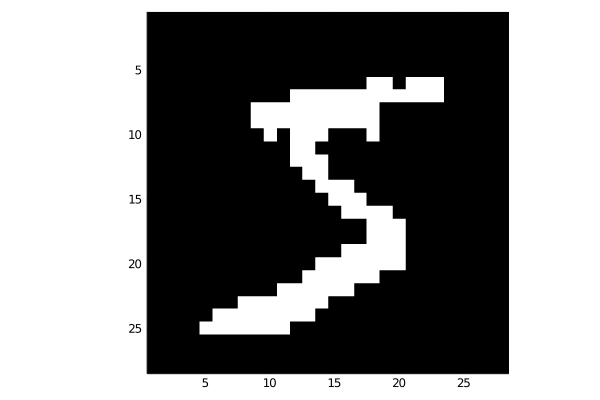

In [148]:
# Visualization
using Images
using Plots
# make vector of digits into images, works on batches also
mnist_img(x) = ndims(x)==2 ? Gray.(reshape(x,28,28,:))' : Gray.(reshape(x,28,28))'

## Example for how to use mnist_img to plot digit from training data
plot(mnist_img(train_x[:,1]))

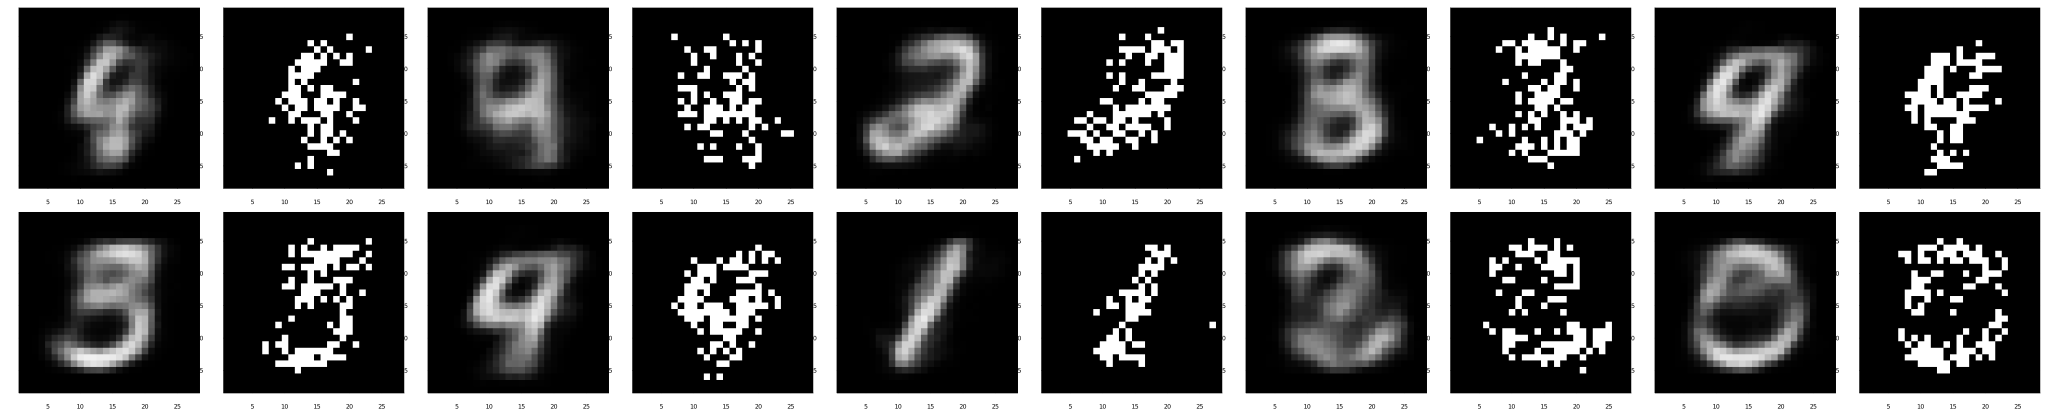

In [368]:
# Sample a z from the prior
plot_list = Any[]
for i in 1:10
    z = sample_diag_gaussian([0, 0],0)
    # Use generative model to compute the bernoulli means over the pixels of x given z.
    θ = decoder(z)
    means = exp.(θ)./(1 .+ exp.(θ))
    # Plot as a greyscale image
    push!(plot_list, plot(mnist_img(means)))
    # Sample a binary image x from this product of Bernoullis. Plot this sample
    out = sample_bernoulli.(means)
    push!(plot_list, plot(mnist_img(out), size=(4000, 800)))
end
display(plot(plot_list..., layout=grid(2,10)))
savefig("3a")

In [369]:
# 3b
encodings = encoder(train_x)
means = encodings[1]
scatter(means[1,:], means[2,:], group=train_label, title = "2D Latent Space")
savefig("3b")

In [152]:
# 3c
function li(za, zb, alpha=0.5)
    return (alpha .* za) .+ ((1 .- alpha) .* zb)
end

li (generic function with 2 methods)

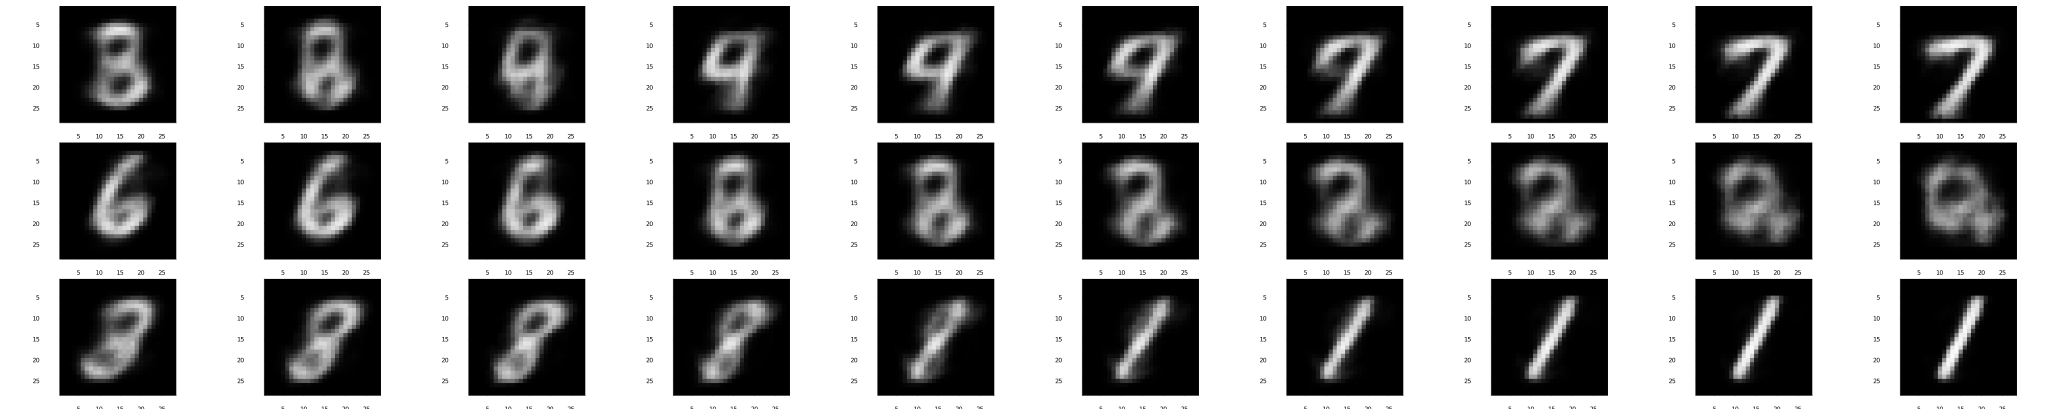

Any[[8, 7], [6, 2], [3, 1]]

In [379]:
# 3 pairs of different labels
labels = []
for i in 1:3
    push!(labels, sample([0,1,2,3,4,5,6,7,8,9], 2; replace=false))
end

# 3 pairs of images
images = []
for pair in labels
    s1 = train_x[:, train_label .== pair[1]]
    s2 = train_x[:, train_label .== pair[2]]
    image1 = s1[:,rand(1:size(s1)[2])]
    image2 = s2[:,rand(1:size(s2)[2])]
    push!(images, [encoder(image1)[1], encoder(image2)[1]])
end

# 10 interpolations per pair
plot_list = []
for pair in images
    for alpha in 0.1:0.1:1
        interp = li(pair[2], pair[1], alpha)
        θ = decoder(interp[:,1])
        means = exp.(θ)./(1 .+ exp.(θ))
        # Plot as a greyscale image
        push!(plot_list, plot(mnist_img(means), size=(4000,800)))
    end
end
print(labels)
display(plot(plot_list..., layout=grid(3,10)))
savefig("3c")

In [378]:
# Write a funciton that computes p(z|top half of the image)
function top_half(x)
    y = reshape(x, 28, 28,:)
    z = y[:,1:14,:]
    return reshape(z, (392,:))
end

top_half (generic function with 1 method)

In [268]:
# Write a function that computes log p(top half of image x | z)
function top_log_px_z(x, z)
    θ = decoder(z)
    return sum(bernoulli_log_density(top_half(θ), top_half(x)), dims=1)
end

top_log_px_z (generic function with 1 method)

In [269]:
# Combine this likelihood with the prior to get a function that computes the joint log density
function joint_log_density_top(x, z)
    return log_prior(z) + top_log_px_z(x, z)
end

joint_log_density_top (generic function with 1 method)

In [270]:
# Initialize mu and sigma
μ = randn(2)
logσ = randn(2)

2-element Array{Float64,1}:
 -0.5729496612244851
  0.6979715705958125

In [271]:
# Write a function that computes ELBO over K samples
function elbo_th(x, opts, k)
    μ, logσ = opts
    z = sample_diag_gaussian(repeat(μ, 1, k), logσ)
    joint_ll = joint_log_density_top(x, z)
    log_q_z = log_q(μ, logσ, z)
    elbo_estimate = mean(joint_ll .- log_q_z)
    return elbo_estimate
end

function loss_th(x, opts, k)
    return -elbo_th(x, opts, k)
end

loss_th (generic function with 1 method)

In [351]:
s = train_x[:, rand(1:1000)]
function train(opts, t_x, iters=200, lr=1e-2, k=10)
    opts_cur = opts
#     x = t_x[:, rand(1:1000)]
    x = t_x
    for i in 1:iters
        opts_grad = gradient(opts_cur -> loss_th(x, opts_cur, k), opts_cur)
        opts_cur[1] .-= lr .* opts_grad[1][1]
        opts_cur[2] .-= lr .* opts_grad[1][2]
        @info "Elbo:" elbo_th = elbo_th(x, opts_cur, k)
    end
    return opts_cur
end

train (generic function with 4 methods)

In [352]:
# Train Paramters
opts = μ, logσ
opts = train(opts, s)

┌ Info: Elbo:
│   elbo_th = -169.98603349329397
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -165.95420287090684
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -164.83106911543965
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -163.8392560396522
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -161.03945421164357
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -155.58528266688373
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -146.16359267536757
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -127.87429003861534
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -107.39131512354193
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -84.37019752854565
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -78.36727057800701
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.96124473922133
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.54464909093893
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.83922893475713
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.118079535386
└ @ Main 

┌ Info: Elbo:
│   elbo_th = -74.0605737116073
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.10042421920507
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.90016717819726
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.86095082410823
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.06413723022676
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.95112737352329
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.80170262521956
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.96651796271108
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.95081793683066
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.0293822142082
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.02328225708985
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.98793390819625
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.00159699018744
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -73.83195138625315
└ @ Main In[351]:10
┌ Info: Elbo:
│   elbo_th = -74.00557117409035
└ @ Main In[351]:

([2.005737382198664, -1.7246540738435419], [-2.085276793026296, -2.1422242498431787])

In [353]:
function skillcontour!(f; colour=nothing)
  n = 100
  x = range(-3,stop=3,length=n)
  y = range(-3,stop=3,length=n)
  z_grid = Iterators.product(x,y) # meshgrid for contour
  z_grid = reshape.(collect.(z_grid),:,1) # add single batch dim
  z = f.(z_grid)
  z = getindex.(z,1)'
  max_z = maximum(z)
  levels = [.99, 0.9, 0.8, 0.7,0.6,0.5, 0.4, 0.3, 0.2] .* max_z
  if colour==nothing
      p1 = contour!(x, y, z, fill=false, levels=levels)
  else
      p1 = contour!(x, y, z, fill=false, c=colour,levels=levels,colorbar=false)
  end
  return plot!(p1)
end

skillcontour! (generic function with 1 method)

In [382]:
# Plotting Isocontours
μ, logσ = opts
joint(z) = exp(joint_log_density_top(s, z))
post(z) = exp(log_q(μ, logσ, z))
plot(title="Joint Density vs Approx Posterior Contours")
skillcontour!(joint)
skillcontour!(post)
savefig("4bd")

┌ Warning: Multiple series with different levels share a colorbar. Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\jeffr\.julia\packages\Plots\NVH6y\src\backends\gr.jl:521


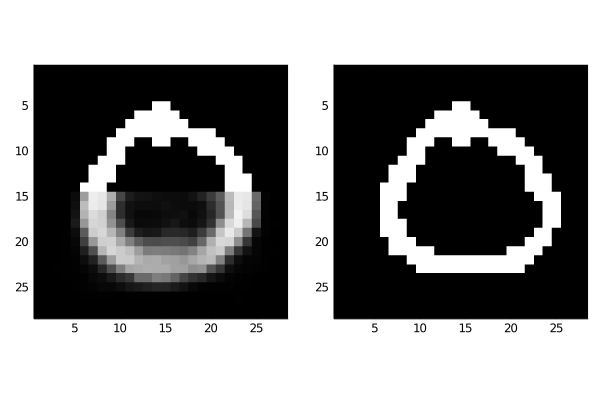

In [383]:
z = sample_diag_gaussian(μ, logσ)

# Use generative model to compute the bernoulli means over the pixels of x given z.
θ = decoder(z)
means = exp.(θ)./(1 .+ exp.(θ))

# Concatenate top half and predicted bottom half
top = top_half(s)
bot = reshape(means, 28, 28, :)
bot = bot[:,15:end,:]
bot = reshape(bot, (392,:))

img = vcat(top, bot)
plot_list = [plot(mnist_img(img[:,1])), plot(mnist_img(s))]
display(plot(plot_list...))
savefig("4be")